In [1]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [2]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)

In [3]:
conv = conv3x3(in_channels=32, out_channels=64)
print(conv)
del conv

Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [5]:
ResidualBlock(32, 64)

ResidualBlock(
  (blocks): Identity()
  (shortcut): Identity()
)

In [6]:
dummy = torch.ones((1, 1, 1, 1))

block = ResidualBlock(1, 64)
block(dummy)

tensor([[[[2.]]]])

In [7]:
from collections import OrderedDict

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [8]:
ResNetResidualBlock(32, 64)

ResNetResidualBlock(
  (blocks): Identity()
  (shortcut): Sequential(
    (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [9]:
from collections import OrderedDict
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

In [10]:
conv_bn(3, 3, nn.Conv2d, kernel_size=3)

Sequential(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [11]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [12]:
dummy = torch.ones((1, 32, 224, 224))

block = ResNetBasicBlock(32, 64)
block(dummy).shape
print(block)

ResNetBasicBlock(
  (blocks): Sequential(
    (0): Sequential(
      (conv): Conv2dAuto(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (shortcut): Sequential(
    (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [13]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [14]:
dummy = torch.ones((1, 32, 10, 10))

block = ResNetBottleNeckBlock(32, 64)
block(dummy).shape
print(block)

ResNetBottleNeckBlock(
  (blocks): Sequential(
    (0): Sequential(
      (conv): Conv2dAuto(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ReLU()
    (2): Sequential(
      (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ReLU()
    (4): Sequential(
      (conv): Conv2dAuto(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (shortcut): Sequential(
    (conv): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [15]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [16]:
dummy = torch.ones((1, 32, 48, 48))

layer = ResNetLayer(64, 128, block=ResNetBasicBlock, n=3)
# layer(dummy).shape
layer

ResNetLayer(
  (blocks): Sequential(
    (0): ResNetBasicBlock(
      (blocks): Sequential(
        (0): Sequential(
          (conv): Conv2dAuto(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): ReLU()
        (2): Sequential(
          (conv): Conv2dAuto(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (shortcut): Sequential(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResNetBasicBlock(
      (blocks): Sequential(
        (0): Sequential(
          (conv): Conv2dAuto(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn

In [17]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [18]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes=40):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [19]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels=3, n_classes=40, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

In [39]:
from torchsummary import summary

model_select = resnet34(3, 40)
# summary(model_select, (3, 224, 224))

In [40]:
import torchvision.models as models

# resnet101(False)

summary(models.resnet34(False).cuda(), (3, 224, 224))

C:\Users\young\anaconda3_1\envs\youngs\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\young\anaconda3_1\envs\youngs\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [23]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from torchvision import datasets, transforms, models

data_dir = './stanford-car-classification/car_ims'

In [24]:
from scipy import io
mat_file = io.loadmat('./stanford-car-classification/devkit/cars_meta.mat')

In [25]:
mat_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Dec 14 14:13:07 2013',
 '__version__': '1.0',
 '__globals__': [],
 'class_names': array([[array(['AM General Hummer SUV 2000'], dtype='<U26'),
         array(['Acura RL Sedan 2012'], dtype='<U19'),
         array(['Acura TL Sedan 2012'], dtype='<U19'),
         array(['Acura TL Type-S 2008'], dtype='<U20'),
         array(['Acura TSX Sedan 2012'], dtype='<U20'),
         array(['Acura Integra Type R 2001'], dtype='<U25'),
         array(['Acura ZDX Hatchback 2012'], dtype='<U24'),
         array(['Aston Martin V8 Vantage Convertible 2012'], dtype='<U40'),
         array(['Aston Martin V8 Vantage Coupe 2012'], dtype='<U34'),
         array(['Aston Martin Virage Convertible 2012'], dtype='<U36'),
         array(['Aston Martin Virage Coupe 2012'], dtype='<U30'),
         array(['Audi RS 4 Convertible 2008'], dtype='<U26'),
         array(['Audi A5 Coupe 2012'], dtype='<U18'),
         array(['Audi TTS Coupe 2012'], d

In [26]:
mat_file.keys()

dict_keys(['__header__', '__version__', '__globals__', 'class_names'])

In [27]:
class_names = []
for i in range(len(mat_file.get('class_names')[0])):
    class_names.append(mat_file.get('class_names')[0][i][0])
class_names = class_names[:40]
print(class_names)
data_frame = len(mat_file.get('class_names')[0][:40])
print(data_frame)

['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW Z4 Convertible 2012

In [72]:
for i in range(40):
    os.makedirs('./train_cars/' + class_names[i])
    os.makedirs('./test_cars/' + class_names[i])
    os.makedirs('./val_cars/' + class_names[i])

In [28]:
mat_train_file = io.loadmat('./stanford-car-classification/devkit/cars_train_annos.mat')
mat_train_file.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations'])

In [29]:
mat_train_file.get('annotations')[0][0][0][0]

array([39], dtype=uint8)

In [30]:
mat_train_file = io.loadmat('./stanford-car-classification/data/cars_annos.mat')
box = []
for i in range(3303):
    temp = []
    for j in range(1,5,1):
        temp.append(mat_train_file.get('annotations')[0][i][j][0][0])
    box.append(temp)
box

[[112, 7, 853, 717],
 [48, 24, 441, 202],
 [7, 4, 277, 180],
 [33, 50, 197, 150],
 [5, 8, 83, 58],
 [10, 6, 250, 110],
 [56, 1, 394, 176],
 [1, 13, 113, 83],
 [15, 111, 271, 272],
 [14, 18, 148, 107],
 [5, 8, 91, 59],
 [29, 18, 157, 86],
 [1, 1, 300, 179],
 [9, 1, 152, 103],
 [4, 15, 94, 63],
 [12, 16, 117, 71],
 [1, 5, 160, 89],
 [46, 84, 661, 428],
 [86, 81, 371, 252],
 [26, 32, 677, 418],
 [50, 127, 587, 396],
 [6, 9, 124, 89],
 [52, 25, 751, 507],
 [3, 23, 132, 98],
 [60, 76, 593, 393],
 [21, 18, 492, 316],
 [11, 31, 490, 266],
 [8, 3, 135, 86],
 [30, 65, 331, 199],
 [5, 14, 93, 58],
 [125, 645, 1845, 1421],
 [20, 48, 385, 283],
 [51, 73, 570, 426],
 [79, 469, 1537, 1198],
 [18, 18, 328, 190],
 [13, 235, 2021, 1253],
 [6, 20, 123, 88],
 [26, 25, 283, 157],
 [61, 98, 458, 376],
 [111, 213, 907, 683],
 [178, 214, 901, 658],
 [9, 14, 490, 368],
 [28, 48, 663, 302],
 [4, 9, 96, 88],
 [6, 7, 94, 68],
 [14, 16, 268, 169],
 [10, 18, 89, 61],
 [111, 54, 365, 190],
 [9, 33, 479, 276],
 [9, 

In [31]:
image_files = ['./stanford-car-classification/' + mat_train_file.get('annotations')[0][i][0][0] for i in range(3303)]
               
print(image_files)

['./stanford-car-classification/car_ims/000001.jpg', './stanford-car-classification/car_ims/000002.jpg', './stanford-car-classification/car_ims/000003.jpg', './stanford-car-classification/car_ims/000004.jpg', './stanford-car-classification/car_ims/000005.jpg', './stanford-car-classification/car_ims/000006.jpg', './stanford-car-classification/car_ims/000007.jpg', './stanford-car-classification/car_ims/000008.jpg', './stanford-car-classification/car_ims/000009.jpg', './stanford-car-classification/car_ims/000010.jpg', './stanford-car-classification/car_ims/000011.jpg', './stanford-car-classification/car_ims/000012.jpg', './stanford-car-classification/car_ims/000013.jpg', './stanford-car-classification/car_ims/000014.jpg', './stanford-car-classification/car_ims/000015.jpg', './stanford-car-classification/car_ims/000016.jpg', './stanford-car-classification/car_ims/000017.jpg', './stanford-car-classification/car_ims/000018.jpg', './stanford-car-classification/car_ims/000019.jpg', './stanford

In [79]:
def process_image(i,image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # Resize the images where the shortest side is 256 pixels, keeping the aspect ratio
    pil_image = Image.open(image)
    pil_image = pil_image.crop((round(box[i][0]), round(box[i][1]), round(box[i][2]), round(box[i][3])))
    pil_image = pil_image.resize((224, 224))
    
    return pil_image

In [80]:
# Prepare training, validation, and test data lists
# import math

valid_frac, test_frac = 0.2, 0.2
trainX = []
valX = []
testX = []


for k in range(40):
    for i in range(82):
        rann = np.random.random()
        if rann < valid_frac:
            valX.append(image_files[82*k+i])
            j = image_files[82*k+i]
            r = j.split('/')[-1]
            process_image(82*k+i,j).save(f'./val_cars/{class_names[k]}/{r}')
        elif rann < test_frac + valid_frac:
            testX.append(image_files[82*k+i])
            j = image_files[82*k+i]
            r = j.split('/')[-1]
            process_image(82*k+i,j).save(f'./test_cars/{class_names[k]}/{r}')
        else:
            trainX.append(image_files[82*k+i])
            j = image_files[82*k+i]
            r = j.split('/')[-1]    
            process_image(82*k+i,j).save(f'./train_cars/{class_names[k]}/{r}')
    
print(len(trainX), len(valX), len(testX))
print(trainX)

1962 629 689
['./stanford-car-classification/car_ims/000002.jpg', './stanford-car-classification/car_ims/000004.jpg', './stanford-car-classification/car_ims/000005.jpg', './stanford-car-classification/car_ims/000006.jpg', './stanford-car-classification/car_ims/000009.jpg', './stanford-car-classification/car_ims/000010.jpg', './stanford-car-classification/car_ims/000011.jpg', './stanford-car-classification/car_ims/000012.jpg', './stanford-car-classification/car_ims/000014.jpg', './stanford-car-classification/car_ims/000016.jpg', './stanford-car-classification/car_ims/000017.jpg', './stanford-car-classification/car_ims/000018.jpg', './stanford-car-classification/car_ims/000020.jpg', './stanford-car-classification/car_ims/000021.jpg', './stanford-car-classification/car_ims/000023.jpg', './stanford-car-classification/car_ims/000024.jpg', './stanford-car-classification/car_ims/000026.jpg', './stanford-car-classification/car_ims/000028.jpg', './stanford-car-classification/car_ims/000029.jpg'

In [32]:
# norm_mean = [0.485, 0.456, 0.406] 
# norm_std = [0.229, 0.224, 0.225] 
train_dir = './train_cars'
val_dir = './val_cars'
test_dir = './test_cars'
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



# TODO: Load the datasets with imageFolder
image_datasets = {}
image_datasets["train"] = datasets.ImageFolder(root = train_dir, transform=transform)
image_datasets["valid"] = datasets.ImageFolder(root = val_dir, transform=transform)
image_datasets["test"] = datasets.ImageFolder(root = test_dir, transform=transform)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

# TODO: Using the image datasets and the transforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(image_datasets["train"], batch_size=batch_size, shuffle = True,
                                          num_workers = 2)
valid_loader = torch.utils.data.DataLoader(image_datasets["valid"], batch_size=batch_size, shuffle = False,
                                          num_workers = 2)
test_loader = torch.utils.data.DataLoader(image_datasets["test"], batch_size=batch_size, shuffle = False,
                                         num_workers = 2)

print(dataset_sizes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'train': 1962, 'valid': 629, 'test': 689}
cuda:0


In [45]:
import argparse

# TODO: Build and train your network
def prep_model(arch):
    
    vgg16='' 
    alexnet='' 
    densenet161='' 
    resnet18=''
    resnet181=''
    resnet34=''
    resnet50=''
    resnet152=''
    googlenet=''
    
    #Only download the model you need, kill program if one of the three models isn't passed 
    if arch == 'vgg': 
        vgg16 = models.vgg16(pretrained=True) 
        
    elif arch == 'alexnet': 
        alexnet = models.alexnet(pretrained=True) 
        
    elif arch == 'densenet': 
        densenet161 = models.densenet161(pretrained=True) 
    
    elif '18' in arch:
        resnet18 = models.resnet181(pretrained=True)
        
    elif arch == 'resnet181':
        resnet181 = models.resnet181(pretrained=True)
        
    elif arch == 'resnet34':
        resnet34 = models.resnet34(pretrained=True)
        
    elif arch == 'resnet50':
        resnet50 = models.resnet50(pretrained=True)
        
    elif arch == 'resnet152':
        resnet152 = models.resnet152(pretrained=True)
        
    elif arch == 'googlenet':
        googlenet = models.googlenet(pretrained=True)
        
    else: 
        print('{} architecture not recognized. Supported args: \'vgg\', \'alexnet\', \'densenet\', \'resnet\', \'googlenet\''.format(arch)) 
        sys.exit() 
    
    
     
    #Pass the model, and grab the input size 
    model_select = {'vgg':vgg16,'alexnet':alexnet,'densenet':densenet161,'resnet18':resnet18,'resnet181':resnet181,
                    'resnet34':resnet34,'resnet50':resnet50,'resnet152':resnet152,'googlenet':googlenet} 
    input_size = {'vgg':25088,'alexnet':9216,'densenet':2208,
                  'resnet18':512,'resnet181':512,'resnet34':2048,
                  'resnet50':2048,'resnet152':2048,'googlenet':1024} 
    return model_select[arch], input_size[arch] 
parser = argparse.ArgumentParser()
save_dir = input("Write saved file name: ")
arch = input("Choose one model you like among vgg, alexnet, densenet, resnet, or googlenet?: ")
lr = input("Write learning rate: ")
hiddenunits = input("Write hidden units: ")
e = input("Write training epochs: ")
g = input("Please type gpu ('store_true' or 'store_false'): ")
parser.add_argument('-save_dir', action="store", dest="save_dir")
parser.add_argument('-arch', action="store", dest="arch")
parser.add_argument('-learningrate', action="store", dest="learningrate", type=float)
parser.add_argument('-hiddenunits', action="store", dest="hiddenunits", type=int)
parser.add_argument('-epochs', action="store", dest="epochs", type=int)
parser.add_argument('-gpu', action=g, default=None)
ins=parser.parse_args(['-save_dir', save_dir, '-arch', arch, '-learningrate', lr, '-hiddenunits', hiddenunits, '-epochs', e, '-gpu'])

model_select, input_size = prep_model(ins.arch)

Write saved file name: vgg_cars
Choose one model you like among vgg, alexnet, densenet, resnet, or googlenet?: vgg
Write learning rate: 0.001
Write hidden units: 1024
Write training epochs: 100
Please type gpu ('store_true' or 'store_false'): store_true


C:\Users\young\anaconda3_1\envs\youngs\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\young\anaconda3_1\envs\youngs\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
from collections import OrderedDict
import torch.nn as nn

for param in model_select.parameters():
    param.requires_grad = False

num_class=40
# and final output 10, since tht we have 10 kinds of animals. 
classifier = nn.Sequential(OrderedDict([     
                          ('dropout1', nn.Dropout(0.1)),
                          ('fc1', nn.Linear(input_size, ins.hiddenunits)), 
                          ('relu1', nn.ReLU()),
                          ('dropout2', nn.Dropout(0.1)),
                          ('fc2', nn.Linear(ins.hiddenunits, num_class)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replace model's old classifier with the new classifier
model_select.classifier = classifier
classifier

Sequential(
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=25088, out_features=1024, bias=True)
  (relu1): ReLU()
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=1024, out_features=40, bias=True)
  (output): LogSoftmax(dim=1)
)

In [47]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [48]:
import torch.optim as optim

criterion = nn.NLLLoss()

optimizer = optim.Adam(model_select.classifier.parameters(), lr = ins.learningrate)
model_select.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [49]:
from torch.autograd import Variable
import time

valid_losses=[]
avg_train_losses=[]
avg_valid_losses=[]
train_accuracy=[]
valid_accuracy=[]

class EarlyStopping:
    """If validation loss was not improved, stop the training"""
    def __init__(self, patience=7, verbose=False, delta=0, path='cars_checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        

# early_stopping object의 초기화
early_stopping = EarlyStopping(patience = 20, verbose = True)

def validation(model, validloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        
        output = model(images)
        loss = criterion(output, labels)
        valid_losses.append(loss.item())
        
        probability = torch.exp(output)
        equality = labels.data == probability.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()
    return valid_losses, accuracy

# Training
def train():
    print("Training started...", end="\n\n")
    start_time = time.time()
    iteration=0
    train_losses=[]
    # num_epochs=100
    for epoch in range(ins.epochs):
        # Reset variables at 0 epoch
        model_select.train() # Training Mode
        iter_loss=0.0
        correct = 0
        total = 0
        for i,(inputs,labels) in enumerate(train_loader):

            inputs=Variable(inputs)
            labels=Variable(labels)
            #print(labels.size())
            # if CUDA is avaible, shift to GPU (CUDA)
            CUDA=torch.cuda.is_available()
            if CUDA:
                inputs=inputs.cuda()
                labels=labels.cuda()

            optimizer.zero_grad() # clear gradient
            outputs=model_select(inputs)
            loss=criterion(outputs,labels)
            loss.requires_grad_(True)
            #iter_loss += loss.item() # Accumulate loss
            loss.backward() # backpropagation
            optimizer.step() # update weights
            train_losses.append(loss.item())

            # Save the correct predictions for training data
            _,predicted=torch.max(outputs,1)
            total += labels.size(0)
            correct +=(predicted.cpu()==labels.cpu()).sum()
            iteration +=1

            if (iteration+1) % len(train_loader) == 0:
                model_select.eval()
                with torch.no_grad():
                    validation_losses, validation_accuracy = validation(
                        model_select, valid_loader, criterion
                    )
                train_loss = np.average(train_losses)
                valid_loss = np.average(validation_losses)
                avg_train_losses.append(train_loss)
                avg_valid_losses.append(valid_loss)
                train_accuracy.append(correct/total * 100.)
                valid_accuracy.append(validation_accuracy/len(valid_loader) * 100.)
                print(
                    f"Epoch: {epoch + 1} / {ins.epochs}.."
                    f"Training Loss: {train_loss:.3f}.."
                    f"Training Accuracy: {train_accuracy[-1]:.3f}%.."
                    f"Validation Loss: {valid_loss:.3f}.."
                    f"Validation Accuracy: {valid_accuracy[-1]:.3f}%.."
                )
                
                # clear lists to track next epoch
                train_losses, valid_losses = [], []
                
                model_select.train()
                
        early_stopping(valid_loss, model_select)
        if early_stopping.early_stop:
            print("Early stopping")
            break
                    
    model_select.load_state_dict(torch.load('cars_checkpoint.pt'))
          
    end_time = time.time()
    
    print(f"\nModel took {(end_time - start_time)/3600:.2f} hour(s) to train...")
    return model_select

In [50]:
model_select = train()

Training started...

Epoch: 1 / 100..Training Loss: 3.665..Training Accuracy: 18.084%..Validation Loss: 2.479..Validation Accuracy: 30.342%..
Validation loss decreased (inf --> 2.479474). Saving model ...
Epoch: 2 / 100..Training Loss: 1.071..Training Accuracy: 70.594%..Validation Loss: 2.239..Validation Accuracy: 43.170%..
Validation loss decreased (2.479474 --> 2.238919). Saving model ...
Epoch: 3 / 100..Training Loss: 0.322..Training Accuracy: 91.906%..Validation Loss: 2.124..Validation Accuracy: 48.400%..
Validation loss decreased (2.238919 --> 2.124357). Saving model ...
Epoch: 4 / 100..Training Loss: 0.123..Training Accuracy: 97.490%..Validation Loss: 2.115..Validation Accuracy: 48.251%..
Validation loss decreased (2.124357 --> 2.114953). Saving model ...
Epoch: 5 / 100..Training Loss: 0.070..Training Accuracy: 98.822%..Validation Loss: 2.083..Validation Accuracy: 51.071%..
Validation loss decreased (2.114953 --> 2.083155). Saving model ...
Epoch: 6 / 100..Training Loss: 0.040..T

In [57]:
def check_accuracy_on_test(testloader, model, gpu):
    if gpu and use_gpu:
        print('GPU testing')
        model.cuda()
    elif gpu and use_gpu == False:
        print('GPU processing selected but no NVIDIA drivers found... testing under CPU.')
    else:
        print('CPU testing')
    model.eval()
    accuracy = 0
    test_loss = 0
    for images, labels in iter(testloader):
        images, labels = Variable(images), Variable(labels)
        if gpu and use_gpu:
            images, labels = images.cuda(), labels.cuda()
        with torch.no_grad():
                
                
            output = model.forward(images)
            test_loss += criterion(output, labels).data.item()
            ps = torch.exp(output).data
            equality = (labels.data == ps.max(1)[1])
            accuracy += equality.type_as(torch.FloatTensor()).mean()
                
                
    print(
            "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
            "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
    
check_accuracy_on_test(test_loader, model_select, ins.gpu)

GPU testing
Test Loss: 1.952..  Test Accuracy: 0.479


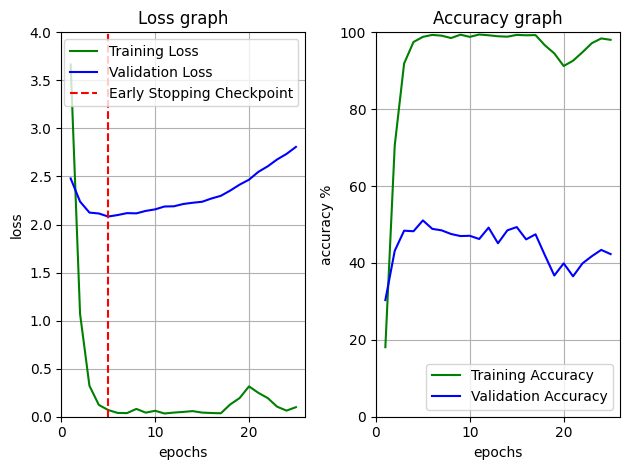

In [58]:
# Visualizing the Loss, Accuracy, and the Early Stopping Checkpoint  
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
#fig1 = plt.figure(figsize=(10,8))
ax1.set_title('Loss graph')
ax1.plot(range(1, len(avg_train_losses)+1), avg_train_losses, 'g', label='Training Loss')
ax1.plot(range(1, len(avg_valid_losses)+1), avg_valid_losses, 'b', label='Validation Loss')
minposs = avg_valid_losses.index(min(avg_valid_losses))+1
ax1.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 4)
ax1.set_xlim(0, len(avg_train_losses)+1)
ax1.grid(True)
ax1.legend(loc = 'upper right')
plt.tight_layout()
#ax1.show()
#fig1.savefig('loss_plot.png', bbox_inches = 'tight')

ax2 = fig.add_subplot(1, 2, 2)
#fig2 = plt.figure(figsize=(10,8))
ax2.set_title('Accuracy graph')
ax2.plot(range(1, len(train_accuracy)+1), train_accuracy, 'g', label='Training Accuracy') 
ax2.plot(range(1, len(valid_accuracy)+1), valid_accuracy, 'b', label='Validation Accuracy')
#maxposs = np.argmax(valid_accuracy) + 1
#plt.axvline(maxposs, linestyle='--', color='r', label='Early Stopping Checkpoint')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy %')
ax2.set_ylim(0, 100)
ax2.set_xlim(0, len(train_accuracy)+1)
ax2.grid(True)
ax2.legend(loc = 'lower right')
plt.tight_layout()
plt.show()
fig.savefig('loss_accuracy_plot.png', bbox_inches = 'tight')